# Uncertainty Quantification using scikit-learn-Ensembles

This notebook demonstrates how to create, train, and evaluate a ensemble using probly and Scikit-Learn.

**Goal:** Compare a standard single model against an ensemble to show how ensembles capture **epistemic uncertainty** (uncertainty due to lack of data).

**Scenario:** We will train a Neural Network on a dataset with a "gap" (missing data in the middle).
1. The **Single Model** will likely be overconfident in the gap.
2. The **Ensemble** should show high variance (uncertainty) in the gap.

Let's start with the imports:

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import clone
from sklearn.neural_network import MLPRegressor

from probly.transformation.ensemble import ensemble

Now, we generate some synthetic data with a gap:

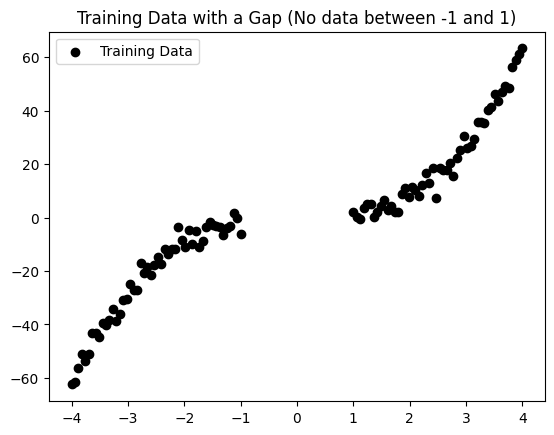

In [ ]:
def generate_gap_data(n_samples: int = 100) -> tuple[np.ndarray, np.ndarray]:
    np.random.seed(42)
    # Create data in two distinct clusters, leaving a gap in [-1, 1]
    x = np.concatenate(
        [
            np.linspace(-4, -1, n_samples // 2),
            np.linspace(1, 4, n_samples // 2),
        ],
    ).reshape(-1, 1)

    # Target function: y = x^3 + noise
    y = x.ravel() ** 3 + np.random.normal(0, 3, x.shape[0])
    return x, y


x_train, y_train = generate_gap_data()

# Test data spans the hole to visualize extrapolation
x_test = np.linspace(-5, 5, 200).reshape(-1, 1)
y_true = x_test.ravel() ** 3

# Visualize the setup
plt.scatter(x_train, y_train, color="black", label="Training Data")
plt.title("Training Data with a Gap (No data between -1 and 1)")
plt.legend()
plt.show()

## Defining the Base Model

We use an `MLPRegressor` (Neural Network). Neural networks are ideal for Deep Ensembles because they are sensitive to random initialization. By resetting the parameters for each member, we generate diverse functions that fit the training data but behave differently in the gap.

In [ ]:
# Define the Base Estimator
# We use a large network to allow for flexibility/variance
base_model = MLPRegressor(
    hidden_layer_sizes=(100, 100),
    activation="relu",
    solver="adam",
    max_iter=2000,
    random_state=42,
)

# Create the Ensemble
# reset_params=True is important: it ensures each member starts with different weights
num_members = 10
ensemble_members = ensemble(base_model, num_members=num_members, reset_params=True)

print(f"Ensemble created with {len(ensemble_members)} members.")

# Train the Ensemble
print("Training ensemble members...")
for model in ensemble_members:
    model.fit(x_train, y_train)
print("Ensemble training complete.")

# Train a Single Control Model for comparison
single_model = clone(base_model)
single_model.fit(x_train, y_train)
print("Single model training complete.")

Ensemble created with 10 members.
Training ensemble members...


c:\Users\tim\probly\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Ensemble training complete.
Single model training complete.


## Predictions and Uncertainty Calculation

For the **Single Model**, we just get one prediction line.
For the **Ensemble**, we collect predictions from all members.
* **Mean:** The consensus prediction.
* **Standard Deviation (Std):** Measures the disagreement. High Std = High Uncertainty.

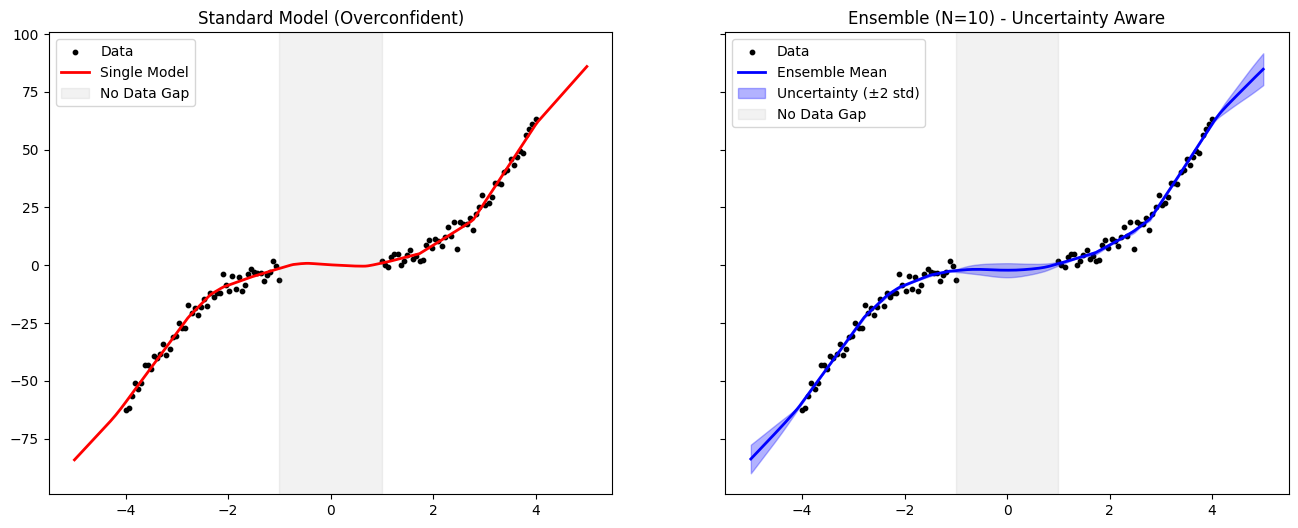

In [ ]:
# Make Predictions

# Single Model
y_pred_single = single_model.predict(x_test)

# Ensemble: Collect predictions from all members
preds_stack = np.column_stack([m.predict(x_test) for m in ensemble_members])

# Calculate Mean and Uncertainty (Std Dev)
y_mean = np.mean(preds_stack, axis=1)
y_std = np.std(preds_stack, axis=1)

# Define Confidence Interval (e.g., +/- 2 Std Dev)
lower = y_mean - 2 * y_std
upper = y_mean + 2 * y_std

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot Single Model
axes[0].scatter(x_train, y_train, color="black", s=10, label="Data")
axes[0].plot(x_test, y_pred_single, color="red", linewidth=2, label="Single Model")
axes[0].set_title("Standard Model (Overconfident)")
axes[0].axvspan(-1, 1, color="gray", alpha=0.1, label="No Data Gap")
axes[0].legend()

# Plot Ensemble
axes[1].scatter(x_train, y_train, color="black", s=10, label="Data")
axes[1].plot(x_test, y_mean, color="blue", linewidth=2, label="Ensemble Mean")
# Shaded area represents uncertainty
axes[1].fill_between(x_test.ravel(), lower, upper, color="blue", alpha=0.3, label="Uncertainty (±2 std)")
axes[1].set_title(f"Ensemble (N={num_members}) - Uncertainty Aware")
axes[1].axvspan(-1, 1, color="gray", alpha=0.1, label="No Data Gap")
axes[1].legend()

plt.show()

## Conclusion

As seen in the plots above:

1.  **The Standard Model** interpolates across the gap (gray zone) with a single, confident line. It gives no indication that it is "guessing" in that region.
2.  **The Ensemble** shows a wide shaded area in the gap. The individual members disagree on the function shape where no data exists. 

**Result:** The ensemble implementation successfully makes the model **uncertainty-aware**. It provides a measure of confidence that allows us to trust predictions in the data-dense regions while flagging predictions in the dataless regions as uncertain.